# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Setup

### Imports

In [1]:
# standard library
import datetime
import math

In [2]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn

### Date this Notebook was run

In [3]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-09-26'

### Set Defaults

In [4]:
# style like ggplot in R
plt.style.use('ggplot')

In [5]:
# Avoid cutting off part of the axis labels, see:
# https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.rcParams.update({'figure.autolayout': True})

In [6]:
population_germany = 83_200_000

## Get and Transform Data

In [7]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

### Drop unnecessary / misleading columns

List all columns:

In [8]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_erst_kumulativ', 'dosen_zweit_kumulativ',
       'dosen_dritt_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_dritt_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'impf_quote_erst', 'impf_quote_voll', 'dosen_dim_kumulativ',
       'dosen_kbv_kumulativ', 'indikation_alter_dosen',
       'indikation_beruf_dosen', 'indikation_medizinisch_dosen',
     

Columns with names starting with 'indikation_' will not be analyzed as the data providers stopped updating them.

In [9]:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

Some more columns can be dropped, as there is no interest in analyzing differences on a vaccine level - especially since in some cases vaccines were mixed.

In [10]:
more_cols_to_drop = ['dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ', 
                    'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
                    'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ']
vaccinations.drop(columns=more_cols_to_drop, inplace=True)

Some columns are labeled misleadingly. As stated by the data provider the columns `personen_erst_kumulativ` and `impf_quote_erst` contain people vaccinated with the Johnson & Johnson vaccine. As this requires only one shot. the same persons are included in `personen_voll_kumulativ`.
Therefore more columns are dropped and recalculated later.

In [11]:
vaccinations.drop(columns=['impf_quote_erst', 'impf_quote_voll'], inplace=True)

Convert datatype of date column

In [12]:
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

### Show Data

In [13]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              272 non-null    datetime64[ns]
 1   dosen_kumulativ                   272 non-null    int64         
 2   dosen_biontech_kumulativ          272 non-null    int64         
 3   dosen_biontech_dritt_kumulativ    272 non-null    int64         
 4   dosen_moderna_kumulativ           272 non-null    int64         
 5   dosen_moderna_dritt_kumulativ     272 non-null    int64         
 6   dosen_astra_kumulativ             272 non-null    int64         
 7   dosen_astra_dritt_kumulativ       272 non-null    int64         
 8   dosen_johnson_kumulativ           272 non-null    int64         
 9   dosen_erst_kumulativ              272 non-null    int64         
 10  dosen_zweit_kumulativ             272 non-null    

In [14]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_dritt_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ
269,2021-09-22,106382767,80967244,473988,9618600,22707,12683643,77,3113280,56117204,...,497408,271145,88633,130935,51577,56117204,52881435,497408,0,0
270,2021-09-23,106644215,81208527,524039,9626511,24193,12684389,79,3124788,56205403,...,548949,261448,88199,121708,51541,56205403,53014651,548949,0,0
271,2021-09-24,106863393,81406933,559199,9635223,25361,12685457,81,3135780,56279314,...,585288,219178,73911,108928,36339,56279314,53134571,585288,0,0


## Check Validity

In [15]:
# get the last row / the newest available data
last_row = vaccinations.tail(1)

In [16]:
doses_used = last_row['dosen_kumulativ']
doses_used

271    106863393
Name: dosen_kumulativ, dtype: int64

In [17]:
# The number of person having been vaccinated at least once, includes those fully vaccinated
at_least_once = last_row['personen_erst_kumulativ']
fully_vaccinated_people = last_row['personen_voll_kumulativ']
partially_vaccinated_people = at_least_once - fully_vaccinated_people
# The johnson & Johnson vaccine is the only one used in Germany that only needs a single shot:
johnson_doses = last_row['dosen_johnson_kumulativ']

In [18]:
# Must be exactly 0
result_substraction = doses_used - partially_vaccinated_people - (fully_vaccinated_people - johnson_doses) * 2 - johnson_doses
result_substraction

271    585288
dtype: int64

In [19]:
result_substraction ==  0

271    False
dtype: bool

## Calculate columns

In [20]:
vaccinations['partly vaccinated'] = round(
    (vaccinations['personen_erst_kumulativ'] - vaccinations['personen_voll_kumulativ']) * 100 / population_germany,
    2)

In [21]:
vaccinations['fully vaccinated'] = round(
    vaccinations['personen_voll_kumulativ'] * 100 / population_germany,
    2)

In [22]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              272 non-null    datetime64[ns]
 1   dosen_kumulativ                   272 non-null    int64         
 2   dosen_biontech_kumulativ          272 non-null    int64         
 3   dosen_biontech_dritt_kumulativ    272 non-null    int64         
 4   dosen_moderna_kumulativ           272 non-null    int64         
 5   dosen_moderna_dritt_kumulativ     272 non-null    int64         
 6   dosen_astra_kumulativ             272 non-null    int64         
 7   dosen_astra_dritt_kumulativ       272 non-null    int64         
 8   dosen_johnson_kumulativ           272 non-null    int64         
 9   dosen_erst_kumulativ              272 non-null    int64         
 10  dosen_zweit_kumulativ             272 non-null    

In [23]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ,partly vaccinated,fully vaccinated
269,2021-09-22,106382767,80967244,473988,9618600,22707,12683643,77,3113280,56117204,...,88633,130935,51577,56117204,52881435,497408,0,0,3.89,63.56
270,2021-09-23,106644215,81208527,524039,9626511,24193,12684389,79,3124788,56205403,...,88199,121708,51541,56205403,53014651,548949,0,0,3.84,63.72
271,2021-09-24,106863393,81406933,559199,9635223,25361,12685457,81,3135780,56279314,...,73911,108928,36339,56279314,53134571,585288,0,0,3.78,63.86


### Last Update

Often the data is not updated on weekends, so get the highest date in the dataset.

In [24]:
last_update = vaccinations.loc[vaccinations.index[-1], "date"].strftime('%Y-%m-%d')
last_update

'2021-09-24'

## Doses Used

In [25]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
# Rename columns
doses.columns = ['date', 'doses used']

In [26]:
# Scale number of doses as millions
doses['doses used'] = doses['doses used'] / 1_000_000

### Doses Daily

In [27]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-09-24,0.219178


In [28]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

1.427928

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

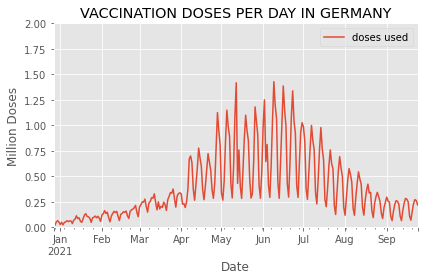

In [29]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily)),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Weekday (in the last 6 weeks)

In [30]:
last_6_weeks = doses.tail(42)

In [31]:
# Yields a warning, but exactly like the docs prescribe and it works
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()

<ipython-input-31-45013977109e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()


In [32]:
# check:
last_6_weeks.tail(3)

,date,doses used,weekday
269,2021-09-22,0.271145,Wednesday
270,2021-09-23,0.261448,Thursday
271,2021-09-24,0.219178,Friday


In [33]:
# drop the date column
last_6_weeks = last_6_weeks.drop(labels=['date'], axis=1)

In [34]:
#last_6_weeks.set_index('weekday', inplace=True)
last_6_weeks.tail(3)

,doses used,weekday
269,0.271145,Wednesday
270,0.261448,Thursday
271,0.219178,Friday


In [35]:
pivot_table =last_6_weeks.pivot(columns='weekday', values='doses used')
pivot_table.tail()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
267,NaN,0.156513,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,0.231932,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,0.271145
270,NaN,NaN,NaN,NaN,0.261448,NaN,NaN
271,0.219178,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Reorder the columns
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
# Rename the columns
pivot_table.columns=['Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_table.tail()

,Mo,Tue,Wed,Thu,Fri,Sat,Sun
267,0.156513,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,0.231932,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,0.271145,NaN,NaN,NaN,NaN
270,NaN,NaN,NaN,0.261448,NaN,NaN,NaN
271,NaN,NaN,NaN,NaN,0.219178,NaN,NaN


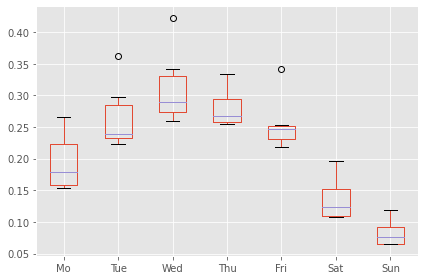

In [37]:
weekday_boxplot = pivot_table.boxplot()

In [38]:
fig = weekday_boxplot.get_figure()
fig.savefig('img/weekday_boxplot.png')

### Doses per Week

In [39]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.columns = ['million doses used']
doses_weekly.tail()

,million doses used
date,
2021-08-30,1.607654
2021-09-06,1.367897
2021-09-13,1.304388
2021-09-20,1.376117
2021-09-27,0.983703


In [40]:
# What is the highest number of doses used in a week?
max_million_doses_weekly = max(doses_weekly['million doses used'])
max_million_doses_weekly

6.122965

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY\n(until 2021-09-24)'}, xlabel='Date', ylabel='Million Doses'>

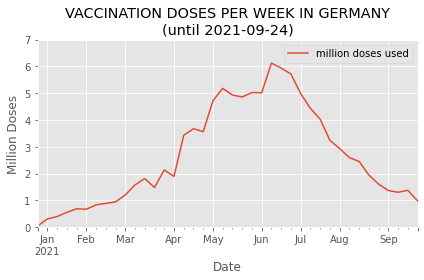

In [41]:
doses_weekly.plot(
    ylim=(0, math.ceil(max_million_doses_weekly)),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER WEEK IN GERMANY\n(until {last_update})")

### Doses per Month

In [42]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2021-05-31,21.051604
2021-06-30,24.751064
2021-07-31,17.252465
2021-08-31,9.256390
2021-09-30,4.788989


In [43]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
April 2021,15.563184
May 2021,21.051604
June 2021,24.751064
July 2021,17.252465
August 2021,9.256390
September 2021,4.788989


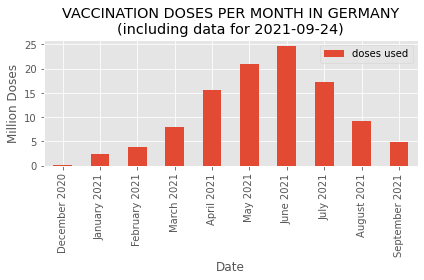

In [44]:
monthly_plot = doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly) + 1),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(including data for {last_update})")

In [45]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_germany.png')

## Vaccination Campaign Progress

In [46]:
doses_cumulative = vaccinations.loc[ : , ['date', 'partly vaccinated', 'fully vaccinated']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.tail(3)

,partly vaccinated,fully vaccinated
date,,
2021-09-22,3.89,63.56
2021-09-23,3.84,63.72
2021-09-24,3.78,63.86


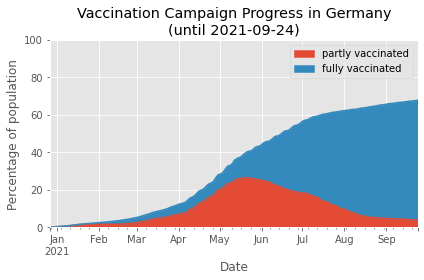

In [47]:
doses_area_plot = doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of population',
    title=f"Vaccination Campaign Progress in Germany\n(until {last_update})")

In [48]:
fig = doses_area_plot.get_figure()
fig.savefig('img/vaccinations_germany_area_plot.png')

### As of Today

In [49]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state

partly vaccinated     3.78
fully vaccinated     63.86
Name: 2021-09-24 00:00:00, dtype: float64

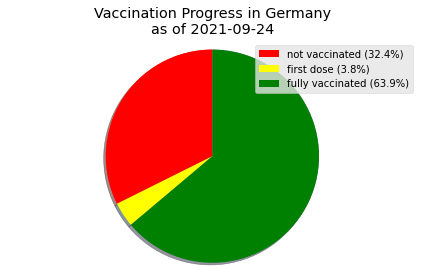

In [50]:
percentage_not_vacc = 100 - current_state['partly vaccinated'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['partly vaccinated'], 1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'], 1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['partly vaccinated'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress in Germany\nas of {last_update}")
# plt.savefig must be before show()
# BEWARE plt.savefig must be in the same Jupyter code cell that creates the graph!
# See comment by ijoseph here:
# https://stackoverflow.com/questions/9012487/matplotlib-pyplot-savefig-outputs-blank-image
plt.savefig('img/vaccination_in_germany_pie.png', bbox_inches='tight')
plt.show()

## Vaccines in Use

In [51]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_erst_kumulativ', 'dosen_zweit_kumulativ',
       'dosen_dritt_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_dritt_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'dosen_dim_kumulativ', 'dosen_kbv_kumulativ', 'partly vaccinated',
       'fully vaccinated'],
      dtype='object')

In [52]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ',
                                     'dosen_moderna_kumulativ',
                                     'dosen_astra_kumulativ',
                                     'dosen_johnson_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'BioNTech', 'Moderna', 'AstraZeneca', 'Johnson & Johnson']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
# divide columns by 1 million
vaccine_use["BioNTech"] = vaccine_use["BioNTech"] / 1_000_000
vaccine_use["Moderna"] = vaccine_use["Moderna"] / 1_000_000
vaccine_use["AstraZeneca"] = vaccine_use["AstraZeneca"] / 1_000_000
vaccine_use["Johnson & Johnson"] = vaccine_use["Johnson & Johnson"] / 1_000_000
vaccine_use.tail(3)

,BioNTech,Moderna,AstraZeneca,Johnson & Johnson
date,,,,
2021-09-22,80.967244,9.618600,12.683643,3.113280
2021-09-23,81.208527,9.626511,12.684389,3.124788
2021-09-24,81.406933,9.635223,12.685457,3.135780


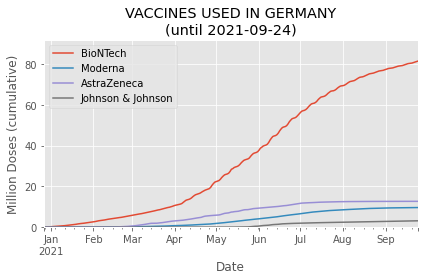

In [53]:
vaccines_used = vaccine_use.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0,math.ceil(max(vaccine_use.iloc[-1]))+10),
    xlabel='Date',
    ylabel='Million Doses (cumulative)',
    title=f"VACCINES USED IN GERMANY\n(until {last_update})")

In [54]:
fig = vaccines_used.get_figure()
fig.savefig('img/vaccines_used_in_germany.png')

# Vaccination Centers versus Doctor’s Practices

In [55]:
vaccinations.tail()

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_erst_kumulativ,...,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ,partly vaccinated,fully vaccinated
267,2021-09-20,105879690,80504331,384312,9601471,19278,12681742,74,3092146,55949791,...,51837,80228,24448,55949791,52617763,404282,0,0,4.00,63.24
268,2021-09-21,106111622,80717626,424579,9609007,20553,12682780,76,3102209,56028571,...,78780,111603,41549,56028571,52739429,445831,0,0,3.95,63.39
269,2021-09-22,106382767,80967244,473988,9618600,22707,12683643,77,3113280,56117204,...,88633,130935,51577,56117204,52881435,497408,0,0,3.89,63.56
270,2021-09-23,106644215,81208527,524039,9626511,24193,12684389,79,3124788,56205403,...,88199,121708,51541,56205403,53014651,548949,0,0,3.84,63.72
271,2021-09-24,106863393,81406933,559199,9635223,25361,12685457,81,3135780,56279314,...,73911,108928,36339,56279314,53134571,585288,0,0,3.78,63.86


In [56]:
by_place = vaccinations.loc[ : , ['date', 'dosen_dim_kumulativ', 'dosen_kbv_kumulativ']]
by_place.columns = ['date', 'vaccination centers', 'practices']

In [57]:
by_place['vaccination centers daily'] = by_place['vaccination centers'].diff()
by_place['practices daily'] = by_place['practices'].diff()

In [58]:
by_place['percentage practices'] =  round(
    by_place['practices daily'] * 100 / 
    (by_place['vaccination centers daily'] + by_place['practices daily']), 2)

by_place['percentage centers'] = 100 - by_place['percentage practices']

In [59]:
# make 'date' an index
by_place.set_index('date', inplace=True)

In [60]:
by_place

,vaccination centers,practices,vaccination centers daily,practices daily,percentage practices,percentage centers
date,,,,,,
2020-12-27,0,0,NaN,NaN,NaN,NaN
2020-12-28,0,0,0.0,0.0,NaN,NaN
2020-12-29,0,0,0.0,0.0,NaN,NaN
2020-12-30,0,0,0.0,0.0,NaN,NaN
2020-12-31,0,0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...
2021-09-20,0,0,0.0,0.0,NaN,NaN
2021-09-21,0,0,0.0,0.0,NaN,NaN
2021-09-22,0,0,0.0,0.0,NaN,NaN


In [61]:
share = by_place.loc[ : , ['percentage centers', 'percentage practices']]

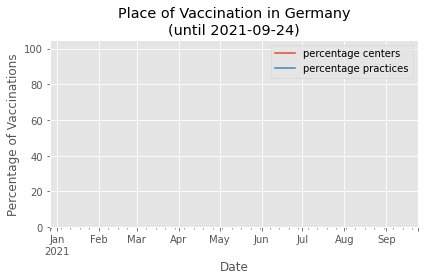

In [62]:
vacc_shares = share.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0, 105),  # above 100 to see the line
    xlabel='Date',
    ylabel='Percentage of Vaccinations',
    title=f"Place of Vaccination in Germany\n(until {last_update})")

In [63]:
fig = vacc_shares.get_figure()
fig.savefig('img/vaccinations_germany_by_place.png')

## Other units of Time

In [64]:
by_place_daily = by_place.loc[ : , ['vaccination centers daily', 'practices daily']]
by_place_daily.columns = ['vaccination centers', 'practices']
by_place_daily.reset_index(inplace=True)

### Monthly

In [65]:
by_place_monthly = by_place_daily.groupby(pd.Grouper(key='date',freq='M')).sum()
by_place_monthly.tail()

,vaccination centers,practices
date,,
2021-05-31,0.0,0.0
2021-06-30,0.0,0.0
2021-07-31,0.0,0.0
2021-08-31,0.0,0.0
2021-09-30,0.0,0.0


Scale:

In [66]:
by_place_monthly['vaccination centers'] = by_place_monthly['vaccination centers'] / 1_000_000
by_place_monthly['practices'] = by_place_monthly['practices'] / 1_000_000

Rename the columns

In [67]:
by_place_monthly['month'] = by_place_monthly.index.strftime('%B')
by_place_monthly['year'] =  by_place_monthly.index.strftime('%Y')
by_place_monthly['label'] = by_place_monthly['month'] + ' ' + by_place_monthly['year']
by_place_monthly.drop(columns=['month', 'year'], inplace=True)
by_place_monthly.set_index('label', inplace=True)
by_place_monthly.tail(6)

,vaccination centers,practices
label,,
April 2021,0.0,0.0
May 2021,0.0,0.0
June 2021,0.0,0.0
July 2021,0.0,0.0
August 2021,0.0,0.0
September 2021,0.0,0.0


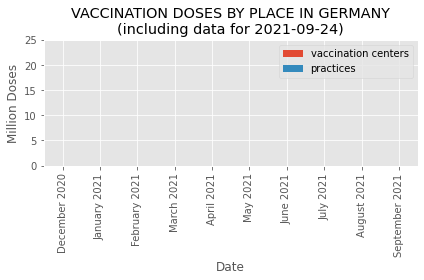

In [68]:
monthly_plot = by_place_monthly.plot.bar(
    stacked=True,
    ylim=(0, 25),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES BY PLACE IN GERMANY\n(including data for {last_update})")

In [69]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_by_place_germany.png')